In [ ]:
import numpy as np
from random import random

class dataGenerator(object):

    def __init__(self, folder, flip=True):
        self.flip = flip
        self.images = np.load(folder)[:, :, :, :]
        self.images = self.images.astype(np.float32)
            
    def get_batch(self, num):

        idx = np.random.randint(0, self.images.shape[0] - 1, num)
        out = []

        for i in idx:
            img = self.images[i]
            if self.flip and random() < 0.5:
                img = np.flip(img, 1)
            out.append(img)

        return np.array(out)




In [ ]:
# -*- coding: utf-8 -*-
"""Convolutional layers.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.python.keras.utils import conv_utils
import tensorflow as tf

class Conv2DMod(Layer):

    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 dilation_rate=1,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 demod=True,
                 **kwargs):
        super(Conv2DMod, self).__init__(**kwargs)
        self.filters = filters
        self.rank = 2
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2, 'dilation_rate')
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.demod = demod
        self.input_spec = [InputSpec(ndim = 4),
                            InputSpec(ndim = 2)]

    def build(self, input_shape):
        channel_axis = -1
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[0][channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        if input_shape[1][-1] != input_dim:
            raise ValueError('The last dimension of modulation input should be equal to input dimension.')

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        # Set input spec.
        self.input_spec = [InputSpec(ndim=4, axes={channel_axis: input_dim}),
                            InputSpec(ndim=2)]
        self.built = True

    def call(self, inputs):

        #To channels last
        x = tf.transpose(inputs[0], [0, 3, 1, 2])

        #Get weight and bias modulations
        #Make sure w's shape is compatible with self.kernel
        w = K.expand_dims(K.expand_dims(K.expand_dims(inputs[1], axis = 1), axis = 1), axis = -1)

        #Add minibatch layer to weights
        wo = K.expand_dims(self.kernel, axis = 0)

        #Modulate
        weights = wo * (w+1)

        #Demodulate
        if self.demod:
            d = K.sqrt(K.sum(K.square(weights), axis=[1,2,3], keepdims = True) + 1e-8)
            weights = weights / d

        #Reshape/scale input
        x = tf.reshape(x, [1, -1, x.shape[2], x.shape[3]]) # Fused => reshape minibatch to convolution groups.
        w = tf.reshape(tf.transpose(weights, [1, 2, 3, 0, 4]), [weights.shape[1], weights.shape[2], weights.shape[3], -1])

        x = tf.nn.conv2d(x, w,
                strides=self.strides,
                padding="SAME",
                data_format="NCHW")

        # Reshape/scale output.
        x = tf.reshape(x, [-1, self.filters, x.shape[2], x.shape[3]]) # Fused => reshape convolution groups back to minibatch.
        x = tf.transpose(x, [0, 2, 3, 1])

        return x

    def compute_output_shape(self, input_shape):
        space = input_shape[0][1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=self.dilation_rate[i])
            new_space.append(new_dim)

        return (input_shape[0],) + tuple(new_space) + (self.filters,)

    def get_config(self):
        config = {
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'dilation_rate': self.dilation_rate,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'demod': self.demod
        }
        base_config = super(Conv2DMod, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
from PIL import Image
from math import floor, log2
import numpy as np
import time
from functools import partial
from random import random
import os
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K

def nImage(n):
    return np.random.normal(0.0, 1.0, size = [n, im_size[0], im_size[1], 1]).astype('float32') #uniform

def noise(n):
    return np.random.normal(0.0, 1.0, size = [n, latent_size]).astype('float32')

def noiseList(n):
    return [noise(n)] * n_layers

def mixedList(n):
    tt = int(random() * n_layers)
    p1 = [noise(n)] * tt
    p2 = [noise(n)] * (n_layers - tt)
    return p1 + [] + p2

#Loss functions
def gradient_penalty(samples, output, weight):
    gradients = K.gradients(output, samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * weight

def hinge_d(y_true, y_pred):
    return K.mean(K.relu(1.0 + (y_true * y_pred)))

def w_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


#Lambdas
def crop_to_fit(x):

    height = x[1].shape[1]
    width = x[1].shape[2]

    return x[0][:, :height, :width, :]

def upsample(x):
    return K.resize_images(x,2,2,"channels_last",interpolation='bilinear')

def upsample_to_size(x):
    x = K.resize_images(x, im_size[0] // x.shape[1], im_size[1] // x.shape[2], "channels_last",interpolation='bilinear')
    return x


#Blocks
def g_block(inp, istyle, inoise, fil, u = True):

    if u:
        #Custom upsampling because of clone_model issue
        out = Lambda(upsample, output_shape=[None, inp.shape[2] * 2, inp.shape[2] * 2, None])(inp)
        #out = UpSampling2D(interpolation='bilinear')(inp)
        #ch = out.shape[-1]
        #out = Conv2D(ch, 3, (1,1), padding='same')(out)
    else:
        out = Activation('linear')(inp)

    rgb_style = Dense(fil, kernel_initializer = VarianceScaling(200/out.shape[2]))(istyle)
    style = Dense(inp.shape[-1], kernel_initializer = 'he_uniform')(istyle)
    delta = Lambda(crop_to_fit)([inoise, out])
    d = Dense(fil, kernel_initializer = 'zeros')(delta)

    out = Conv2DMod(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([out, style])
    out = add([out, d])
    #out = BatchNormalization()(out) #
    out = LeakyReLU(0.2)(out)

    style = Dense(fil, kernel_initializer = 'he_uniform')(istyle)
    d = Dense(fil, kernel_initializer = 'zeros')(delta)

    out = Conv2DMod(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([out, style])
    out = add([out, d])
    #out = BatchNormalization()(out) #
    out = LeakyReLU(0.2)(out)

    return out, to_rgb(out, rgb_style)

def d_block(inp, fil, p = True):

    res = Conv2D(fil, 1, kernel_initializer = 'he_uniform')(inp)

    out = Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(inp)
    #out = BatchNormalization()(out) #
    out = LeakyReLU(0.2)(out)
    out = Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(out)
    #out = BatchNormalization()(out) #
    out = LeakyReLU(0.2)(out)

    out = add([res, out])

    if p:
        out = AveragePooling2D()(out)

    return out

def to_rgb(inp, style):
    size = inp.shape[2]
    #print('to_rgb')
    #print('im_size', im_size)
    #print('inp_size', inp.shape)
    #hf = im_size[0]//inp.shape[1]
    #wf = im_size[1]//inp.shape[2]
    #print('hf', hf)
    #print('wf', wf)
    x = Conv2DMod(3, 1, kernel_initializer = VarianceScaling(200/size), demod = False)([inp, style])
    #out = x
    #while hf >= 2 and wf >= 2:
      #print('out', out.shape)
      #out = UpSampling2D(interpolation='bilinear')(out)
      #hf -= 2
      #wf -= 2
    #out = Conv2D(3, 3, (1,1), padding='same')(out)
    #print('out', out.shape)
    return Lambda(upsample_to_size, output_shape=[None, im_size[0], im_size[1], None])(x)





class GAN(object):

    def __init__(self, steps = 1, lr = 0.0001, decay = 0.00001):

        #Models
        self.D = None
        self.S = None
        self.G = None

        self.GE = None
        self.SE = None

        self.DM = None
        self.AM = None

        #Config
        self.LR = lr
        self.steps = steps
        self.beta = 0.999

        #Init Models
        self.discriminator()
        self.generator()

        self.GMO = Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        self.DMO = Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)

        self.GE = clone_model(self.G)
        self.GE.set_weights(self.G.get_weights())

        self.SE = clone_model(self.S)
        self.SE.set_weights(self.S.get_weights())

    def discriminator(self):

        if self.D:
            return self.D

        inp = Input(shape = [im_size[0], im_size[1], 3])


        x = d_block(inp, 128)   #128 1*cha

        x = d_block(x, 128)   #128 1*cha

        x = d_block(x, 128)   #128 1*cha

        #x = d_block(x, 128)   #64 2*cha

        #x = d_block(x, 128)   #64 2*cha

        #x = d_block(x, 256)
        '''
        x = d_block(x, 4 * cha)   #32

        x = d_block(x, 6 * cha)  #16

        x = d_block(x, 8 * cha)  #8
        '''
        '''
        x = d_block(x, 16 * cha, p=False)  #4

        x = d_block(x, 32 * cha, p = False)  #4
        '''
        x = Flatten()(x)

        x = Dense(1, kernel_initializer = 'he_uniform')(x)

        self.D = Model(inputs = inp, outputs = x)

        return self.D

    def generator(self):

        if self.G:
            return self.G

        # === Style Mapping ===

        self.S = Sequential()

        self.S.add(Dense(100, input_shape = [latent_size]))
        self.S.add(LeakyReLU(0.2))
        self.S.add(Dense(100))
        self.S.add(LeakyReLU(0.2))
        '''
        self.S.add(Dense(100))
        self.S.add(LeakyReLU(0.2))
        
        self.S.add(Dense(100))
        self.S.add(LeakyReLU(0.2))
        '''

        # === Generator ===

        #Inputs
        inp_style = []

        for i in range(n_layers):
            inp_style.append(Input([100]))

        inp_noise = Input([im_size[0], im_size[1], 1])

        #Latent
        x = Lambda(lambda x: x[:, :1] * 0 + 1)(inp_style[0])

        outs = []

        #Actual Model
        x = Dense(24*16*4*cha, activation = 'relu', kernel_initializer = 'random_normal')(x) #24x16
        x = Reshape([24, 16, 4*cha])(x)

        x, r = g_block(x, inp_style[0], inp_noise, 128, u = False)  #4 32 * cha
        outs.append(r)



        x, r = g_block(x, inp_style[1], inp_noise, 128)  #8 16 * cha
        outs.append(r)

        x, r = g_block(x, inp_style[1], inp_noise, 128, u=False)  #8 16 * cha
        outs.append(r)

        '''
        x, r = g_block(x, inp_style[2], inp_noise, 128)  #8 16 * cha
        outs.append(r)
        
        
        x, r = g_block(x, inp_style[3], inp_noise, 128)  #16
        outs.append(r)
        '''
        '''
        x, r = g_block(x, inp_style[3], inp_noise, 6 * cha)  #32
        outs.append(r)
        '''
        '''
        x, r = g_block(x, inp_style[4], inp_noise, 4 * cha)   #64
        outs.append(r)

        x, r = g_block(x, inp_style[5], inp_noise, 2 * cha)   #128
        outs.append(r)

        x, r = g_block(x, inp_style[6], inp_noise, 1 * cha)   #256
        outs.append(r)
        '''

        x = add(outs)

        #x = Lambda(lambda y: y/2 + 0.5)(x) #Use values centered around 0, but normalize to [0, 1], providing better initialization

        x = Activation('tanh')(x)
        self.G = Model(inputs = inp_style + [inp_noise], outputs = x)

        return self.G

    def GenModel(self):

        #Generator Model for Evaluation

        inp_style = []
        style = []

        for i in range(n_layers):
            inp_style.append(Input([latent_size]))
            style.append(self.S(inp_style[-1]))

        inp_noise = Input([im_size[0], im_size[1], 1])

        gf = self.G(style + [inp_noise])

        self.GM = Model(inputs = inp_style + [inp_noise], outputs = gf)

        return self.GM

    def GenModelA(self):

        #Parameter Averaged Generator Model

        inp_style = []
        style = []

        for i in range(n_layers):
            inp_style.append(Input([latent_size]))
            style.append(self.SE(inp_style[-1]))

        inp_noise = Input([im_size[0], im_size[1], 1])

        gf = self.GE(style + [inp_noise])

        self.GMA = Model(inputs = inp_style + [inp_noise], outputs = gf)

        return self.GMA

    def EMA(self):

        #Parameter Averaging

        for i in range(len(self.G.layers)):
            up_weight = self.G.layers[i].get_weights()
            old_weight = self.GE.layers[i].get_weights()
            new_weight = []
            for j in range(len(up_weight)):
                new_weight.append(old_weight[j] * self.beta + (1-self.beta) * up_weight[j])
            self.GE.layers[i].set_weights(new_weight)

        for i in range(len(self.S.layers)):
            up_weight = self.S.layers[i].get_weights()
            old_weight = self.SE.layers[i].get_weights()
            new_weight = []
            for j in range(len(up_weight)):
                new_weight.append(old_weight[j] * self.beta + (1-self.beta) * up_weight[j])
            self.SE.layers[i].set_weights(new_weight)

    def MAinit(self):
        #Reset Parameter Averaging
        self.GE.set_weights(self.G.get_weights())
        self.SE.set_weights(self.S.get_weights())


class StyleGAN(object):

    def __init__(self, dataset_path, steps = 1, lr = 0.0001, decay = 0.00001, silent = True):

        #Init GAN and Eval Models
        self.GAN = GAN(steps = steps, lr = lr, decay = decay)
        self.GAN.GenModel()
        self.GAN.GenModelA()

        self.GAN.G.summary()

        #Data generator (my own code, not from TF 2.0)
        self.im = dataGenerator(dataset_path, flip = True)

        #Set up variables
        self.lastblip = time.clock()

        self.silent = silent

        self.ones = np.random.normal(0.7, 1.2, (BATCH_SIZE, 1)).astype('float32') #np.ones((BATCH_SIZE, 1), dtype=np.float32)
        self.zeros = np.random.normal(0.0, 0.3, (BATCH_SIZE, 1)).astype('float32')#np.zeros((BATCH_SIZE, 1), dtype=np.float32)
        self.nones = -self.ones

        self.pl_mean = 0
        self.av = np.zeros([44])

    def train(self):

        #Train Alternating
        if random() < mixed_prob:
            style = mixedList(BATCH_SIZE)
        else:
            style = noiseList(BATCH_SIZE)

        #Apply penalties every 16 steps
        apply_gradient_penalty = self.GAN.steps % 2 == 0 or self.GAN.steps < 10000
        apply_path_penalty = self.GAN.steps % 16 == 0

        a, b, c, d = self.train_step(self.im.get_batch(BATCH_SIZE), style, nImage(BATCH_SIZE), apply_gradient_penalty, apply_path_penalty)

        #Adjust path length penalty mean
        #d = pl_mean when no penalty is applied
        if self.pl_mean == 0:
            self.pl_mean = np.mean(d)
        self.pl_mean = 0.99*self.pl_mean + 0.01*np.mean(d)

        if self.GAN.steps % 10 == 0 and self.GAN.steps > 20000:
            self.GAN.EMA()

        if self.GAN.steps <= 25000 and self.GAN.steps % 1000 == 2:
            self.GAN.MAinit()

        if np.isnan(a):
            print("NaN Value Error.")
            exit()


        #Print info
        if self.GAN.steps % 100 == 0 and not self.silent:
            print("\n\nRound " + str(self.GAN.steps) + ":")
            print("D:", np.array(a))
            print("G:", np.array(b))
            print("PL:", self.pl_mean)

            s = round((time.clock() - self.lastblip), 4)
            self.lastblip = time.clock()

            steps_per_second = 100 / s
            steps_per_minute = steps_per_second * 60
            steps_per_hour = steps_per_minute * 60
            print("Steps/Second: " + str(round(steps_per_second, 2)))
            print("Steps/Hour: " + str(round(steps_per_hour)))

            min1k = floor(1000/steps_per_minute)
            sec1k = floor(1000/steps_per_second) % 60
            print("1k Steps: " + str(min1k) + ":" + str(sec1k))
            steps_left = 200000 - self.GAN.steps + 1e-7
            hours_left = steps_left // steps_per_hour
            minutes_left = (steps_left // steps_per_minute) % 60

            print("Til Completion: " + str(int(hours_left)) + "h" + str(int(minutes_left)) + "m")
            print()

            #Save Model
            if self.GAN.steps % 500 == 0:
                self.save(self.GAN.steps)
            if self.GAN.steps % 1000 == 0 or (self.GAN.steps % 100 == 0 and self.GAN.steps < 2500):
                self.evaluate(self.GAN.steps)

        self.GAN.steps = self.GAN.steps + 1

    @tf.function
    def train_step(self, images, style, noise, perform_gp = True, perform_pl = False):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #Get style information
            w_space = []
            pl_lengths = self.pl_mean
            for i in range(len(style)):
                w_space.append(self.GAN.S(style[i]))

            #Generate images
            generated_images = self.GAN.G(w_space + [noise])

            #Discriminate
            real_output = self.GAN.D(images, training=True)
            fake_output = self.GAN.D(generated_images, training=True)

            #Hinge loss function
            gen_loss = K.mean(fake_output)
            divergence = K.mean(K.relu(1 + real_output) + K.relu(1 - fake_output))
            disc_loss = divergence

            if perform_gp:
                #R1 gradient penalty
                disc_loss += gradient_penalty(images, real_output, 10)

            if perform_pl:
                #Slightly adjust W space
                w_space_2 = []
                for i in range(len(style)):
                    std = 0.1 / (K.std(w_space[i], axis = 0, keepdims = True) + 1e-8)
                    w_space_2.append(w_space[i] + K.random_normal(tf.shape(w_space[i])) / (std + 1e-8))

                #Generate from slightly adjusted W space
                pl_images = self.GAN.G(w_space_2 + [noise])

                #Get distance after adjustment (path length)
                delta_g = K.mean(K.square(pl_images - generated_images), axis = [1, 2, 3])
                pl_lengths = delta_g

                if self.pl_mean > 0:
                    gen_loss += K.mean(K.square(pl_lengths - self.pl_mean))

        #Get gradients for respective areas
        gradients_of_generator = gen_tape.gradient(gen_loss, self.GAN.GM.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.GAN.D.trainable_variables)

        #Apply gradients
        self.GAN.GMO.apply_gradients(zip(gradients_of_generator, self.GAN.GM.trainable_variables))
        self.GAN.DMO.apply_gradients(zip(gradients_of_discriminator, self.GAN.D.trainable_variables))

        return disc_loss, gen_loss, divergence, pl_lengths

    def generate_interpolation(self, n, n_steps=10):
      output = None
      for i in range(n):
        n1 = noiseList(1)
        n2 = nImage(1)
        p1 = n1 + [n2]
        n1 = noiseList(1)
        n2 = nImage(1)
        p2 = n1 + [n2]
        vectors = interpolate_points(p1, p2, n_steps)
        generated = self.GAN.GM.predict(vectors, batch_size=BATCH_SIZE)
        if output is None:
          output = generated
        else:
          output = np.vstack((output, generated))
      output = np.clip(((output + 1.0)*127.5),0, 255).astype(np.uint8)
      plt.imshow(output)
      plt.show()
    
    def generate(self):
      n1 = noiseList(1)
      n2 = nImage(1)
      with_noise = self.GAN.GM.predict(n1 + [n2], batch_size=BATCH_SIZE)
      to_show1 = np.clip(((with_noise + 1.0)*127.5),0, 255).astype(np.uint8)
      return to_show1
      #plt.figure(figsize=(3,3), dpi=110)
      #plt.imshow(to_show1[0])

    def evaluate(self, num = 0, trunc = 1.0):

        n1 = noiseList(64)
        n2 = seed
        trunc = np.ones([64, 1]) * trunc

        generated_images = self.GAN.GM.predict(n1 + [n2], batch_size = BATCH_SIZE)

        r = []

        for i in range(0, 64, 8):
            r.append(np.concatenate(generated_images[i:i+8], axis = 1))

        c1 = np.concatenate(r, axis = 0)
        to_show = np.clip(((c1 + 1.0)*127.5),0, 255).astype(np.uint8)
        c1 = np.clip(c1, -1.0, 1.0)
        x = Image.fromarray(np.uint8(c1*255))
        plt.figure(figsize=(10,10), dpi=110)
        plt.imshow(to_show)
        path = drive + '/Images12/' + str(num) + ".png"
        
        plt.savefig(path, dpi=110)
        plt.show()
        # Moving Average
        '''
        generated_images = self.GAN.GMA.predict(n1 + [n2, trunc], batch_size = BATCH_SIZE)
        #generated_images = self.generateTruncated(n1, trunc = trunc)

        r = []

        for i in range(0, 64, 8):
            r.append(np.concatenate(generated_images[i:i+8], axis = 1))

        c1 = np.concatenate(r, axis = 0)
        c1 = np.clip(c1, 0.0, 1.0)

        x = Image.fromarray(np.uint8(c1*255))

        x.save(drive + 'Images/' + str(num) + "-ema.png")

        #Mixing Regularities
        nn = noise(8)
        n1 = np.tile(nn, (8, 1))
        n2 = np.repeat(nn, 8, axis = 0)
        tt = int(n_layers / 2)

        p1 = [n1] * tt
        p2 = [n2] * (n_layers - tt)

        latent = p1 + [] + p2

        generated_images = self.GAN.GMA.predict(latent + [nImage(64), trunc], batch_size = BATCH_SIZE)
        #generated_images = self.generateTruncated(latent, trunc = trunc)

        r = []

        for i in range(0, 64, 8):
            r.append(np.concatenate(generated_images[i:i+8], axis = 0))

        c1 = np.concatenate(r, axis = 1)
        c1 = np.clip(c1, 0.0, 1.0)

        x = Image.fromarray(np.uint8(c1*255))

        x.save(drive + 'Images/' + str(num) + "-mr.png")
        '''

    def generateTruncated(self, style, noi = np.zeros([44]), trunc = 0.5, outImage = False, num = 0):

        #Get W's center of mass
        if self.av.shape[0] == 44: #44 is an arbitrary value
            print("Approximating W center of mass")
            self.av = np.mean(self.GAN.S.predict(noise(2000), batch_size = 64), axis = 0)
            self.av = np.expand_dims(self.av, axis = 0)

        if noi.shape[0] == 44:
            noi = nImage(64)

        w_space = []
        pl_lengths = self.pl_mean
        for i in range(len(style)):
            tempStyle = self.GAN.S.predict(style[i])
            tempStyle = trunc * (tempStyle - self.av) + self.av
            w_space.append(tempStyle)

        generated_images = self.GAN.GE.predict(w_space + [noi], batch_size = BATCH_SIZE)

        if outImage:
            r = []

            for i in range(0, 64, 8):
                r.append(np.concatenate(generated_images[i:i+8], axis = 0))

            c1 = np.concatenate(r, axis = 1)
            c1 = np.clip(c1, 0.0, 1.0)

            x = Image.fromarray(np.uint8(c1*255))

            x.save(drive + 'Images10_2/' + str(num) + ".png")

        return generated_images

    def saveModel(self, model, name, num):
        json = model.to_json()
        with open(drive + '/Models12/' + name + ".json", "w") as json_file:
            json_file.write(json)

        model.save_weights(drive + "/Models12/" + name + "_" + str(num) + ".h5")

    def loadModel(self, name, num):
        file = open(drive + "/Models17/" + name + ".json", 'r')
        json = file.read()
        file.close()

        mod = model_from_json(json, custom_objects = {'Conv2DMod': Conv2DMod})
        mod.load_weights(drive + "/Models17/" + name + "_"+str(num) + ".h5")

        return mod

    def save(self, num): #Save JSON and Weights into /Models/
        self.saveModel(self.GAN.S, "sty", num)
        self.saveModel(self.GAN.G, "gen", num)
        self.saveModel(self.GAN.D, "dis", num)

        self.saveModel(self.GAN.GE, "genMA", num)
        self.saveModel(self.GAN.SE, "styMA", num)


    def load(self, num): #Load JSON and Weights from /Models/

        #Load Models
        self.GAN.D = self.loadModel("dis", num)
        self.GAN.S = self.loadModel("sty", num)
        self.GAN.G = self.loadModel("gen", num)

        self.GAN.GE = self.loadModel("genMA", num)
        self.GAN.SE = self.loadModel("styMA", num)

        self.GAN.GenModel()
        self.GAN.GenModelA()

if __name__ == "__main__":

    im_size = (48, 32)
    seed = nImage(64)
    cha = 3
    mixed_prob = 0.9
    n_layers = 2#int(log2(im_size[1]) - 1)
    print(n_layers)
    latent_size = 100
    BATCH_SIZE = 256
    drive = '/content/drive/My Drive/StyleGAN'
    model = StyleGAN(dataset_path='/content/drive/My Drive/dataset.npy', lr = 0.0001, silent = False) #lr = 0.0001
    model.load('9500')
    model.generate()
    #model.generate_interpolation(1)
    #while model.GAN.steps < 1000001:
        #model.train()

    """
    model.load(31)

    n1 = noiseList(64)
    n2 = nImage(64)
    for i in range(50):
        print(i, end = '\r')
        model.generateTruncated(n1, noi = n2, trunc = i / 50, outImage = True, num = i)
    """



2
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 1)            0           input_18[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 4608)         9216        lambda_8[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 24, 16, 12)   0           dense_22[0][0]                   
____________________________________________________________________________________

(1, 48, 32, 3)
(1, 48, 32, 3)
(1, 48, 32, 3)
(1, 48, 32, 3)
(1, 48, 32, 3)
(1, 48, 32, 3)
(1, 48, 32, 3)
(1, 48, 32, 3)


(-0.5, 255.5, 47.5, -0.5)

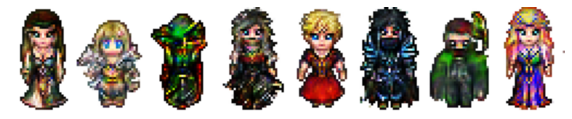

In [ ]:
n = 8
output = None
generated = []
for i in range(n):
  image = model.generate()
  image = np.clip(((image + 1.0)*127.5),0, 255).astype(np.uint8)
  print(image.shape)
  if output is None:
    output = image[0]
  else:
    output = np.hstack([output, image[0]])
plt.figure(figsize=(10, 5))
plt.imshow(output)
plt.axis('off')

In [ ]:
dataset = np.load('/content/drive/My Drive/dataset.npy')

(-0.5, 159.5, 47.5, -0.5)

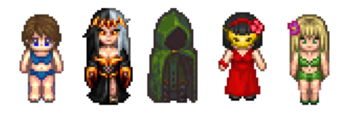

In [ ]:
indices = np.random.choice(len(dataset), size=n, replace=False)
data = None
for id in indices:
  image = np.clip(((dataset[id] + 1.0)*127.5),0, 255).astype(np.uint8)
  if data is None:
    data = image
  else:
    data = np.hstack([data, image])
plt.imshow(data)
plt.axis('off')

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
				self.layerName = self.find_target_layer()
	
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
				# check to see if the layer has a 4D output
				if len(layer.output_shape) == 4:
					return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
						# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)
		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		print(heatmap.shape)
		print(image.shape)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import imutils
import cv2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
model.GAN.D

[[-0.97912353]]
(48, 32, 3)
(48, 32, 3)
(48, 32, 3)


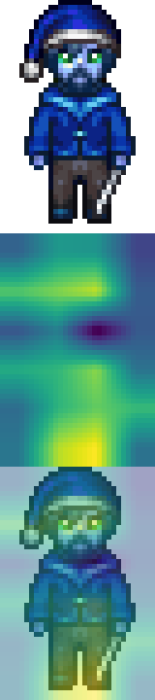

<Figure size 360x720 with 0 Axes>

In [ ]:
from google.colab.patches import cv2_imshow
# use the network to make predictions on the input image and find
# the class label index with the largest corresponding probability
dataset = np.load('/content/drive/My Drive/dataset.npy')
image = dataset[345]
orig = np.clip(((image + 1.0) * 127.5),0,255).astype(np.uint8)
image = np.expand_dims(image, axis=0)
preds = model.GAN.D.predict(image)
print(preds)
i = np.argmax(preds[0])

label = str(i)
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model.GAN.D, i)
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (32, 48))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
o = output
# draw the predicted label on the output image
#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
#cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	#0.8, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
print(output.shape)
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
plt.figure(figsize=(5,10))
#plt.imshow(output)
cv2_imshow(output)

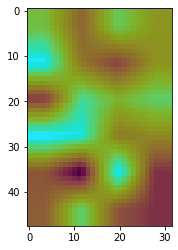

In [ ]:
plt.imshow(heatmap)

In [ ]:
    def interpolate_points(p1, p2, n_steps=10):
      # interpolate ratios between the points
      ratios = np.linspace(0, 1, num=n_steps)
      # linear interpolate vectors
      vectors = list()
      for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
      return np.asarray(vectors)